In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf6.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf7.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf4.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf2.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf1.csv
/kaggle/input/GEF2012-wind-forecasting/benchmark.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf5.csv
/kaggle/input/GEF2012-wind-forecasting/train.csv
/kaggle/input/GEF2012-wind-forecasting/test.csv
/kaggle/input/GEF2012-wind-forecasting/windforecasts_wf3.csv


In [2]:
!pip install gluonts[mxnet]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [5]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime as dt
import matplotlib.dates as mdates
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.split import split

import calendar
import matplotlib.cm as cm
from gluonts.mx import DeepAREstimator, Trainer



In [6]:
DATA_DIRECTORY = "/kaggle/input/GEF2012-wind-forecasting/"
import os
from glob import glob
CSV_FILES = glob(os.path.join(DATA_DIRECTORY, '*.csv'))
CSV_FILES.sort()
for i in range(len(CSV_FILES)):
    CSV_FILES[i] = CSV_FILES[i].rsplit('/', 1)[1]
CSV_FILES

MAJOR_SEPARATOR = "=" * 30
MINOR_SEPARATOR = "-" * 20

DATE_FORMAT = '%Y%m%d%H'
MONTHS = calendar.month_name
CSV_FILES

['benchmark.csv',
 'test.csv',
 'train.csv',
 'windforecasts_wf1.csv',
 'windforecasts_wf2.csv',
 'windforecasts_wf3.csv',
 'windforecasts_wf4.csv',
 'windforecasts_wf5.csv',
 'windforecasts_wf6.csv',
 'windforecasts_wf7.csv']

In [7]:
train_df = pd.read_csv(DATA_DIRECTORY+CSV_FILES[2], index_col='date', date_format=DATE_FORMAT)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18757 entries, 2009-07-01 00:00:00 to 2012-06-26 12:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wp1     18757 non-null  float64
 1   wp2     18757 non-null  float64
 2   wp3     18757 non-null  float64
 3   wp4     18757 non-null  float64
 4   wp5     18757 non-null  float64
 5   wp6     18757 non-null  float64
 6   wp7     18757 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [9]:
from gluonts.dataset.split import TrainingDataset, TestData, TestTemplate
from pandas import Period

class PlotSplitData():
    
    def __init__(self):
        self._plt = plt
        self._plt.rcParams["axes.grid"] = True
        self._plt.rcParams["figure.figsize"] = (20, 3) 
  
    def _highlight_entry(self, entry, color):
        start = entry["start"]
        end = entry["start"] + len(entry["target"])
        self._plt.axvspan(start, end, facecolor=color, alpha=0.2)


    def plot_dataset_splitting(self, original_dataset, training_dataset, test_pairs):
        for original_entry, train_entry in zip(original_dataset, training_dataset):
            to_pandas(original_entry).plot()
            self._highlight_entry(train_entry, "red")
            self._plt.legend(["sub dataset", "training dataset"], loc="upper left")
            self._plt.show()

        for original_entry in original_dataset:
            for test_input, test_label in test_pairs:
                to_pandas(original_entry).plot()
                self._highlight_entry(test_input, "green")
                self._highlight_entry(test_label, "blue")
                self._plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
                self._plt.show()

class TSDataException(BaseException):
    def __init__(self, m):
        self.message = m
    def __str__(self):
        return self.message
    
class TSData:
    def __init__(self, df: pd.DataFrame, expected_freq='1H') -> bool:
        self._df = df
        self._freq = pd.infer_freq(self._df.index) if pd.infer_freq(self._df.index) is not None else expected_freq
        all_idx =  pd.date_range(start=self._df.index[0], end=self._df.index[-1], freq=self._freq)
        self._diagnostics = {"sorted" : self._df.index.is_monotonic_increasing | self._df.index.is_monotonic_decreasing, 
                            "ascending": self._df.index.is_monotonic_increasing, 
                            "descending": self._df.index.is_monotonic_decreasing, 
                            "frequency": self._freq, 
                            "count": self._df[self._df.columns[0]].count(), 
                            "null_count": self._df[self._df.columns[0]].isna().sum(), 
                            "missing_ts_count": len(all_idx.difference(self._df.index))}
        self._dataset = None
        self._ds_split_parameters = None
        
    @property
    def dataframe(self) -> pd.DataFrame:
        return self._df
    
    #inferred frequency of the dataset
    @property
    def frequency(self):
        return self._freq
    
    #Checking if the data is sorted and ascending and is not missing any timesteps
    @property 
    def is_data_ts_ready(self) -> bool:
        retval = True
        retval = retval & self._df.index.is_monotonic_increasing
        retval = retval & (pd.infer_freq(self._df.index) is not None)
        retval = retval & self._df.index.is_unique
        return retval
    
    #index of all the missing timesteps
    @property
    def missing_timesteps(self) -> pd.DatetimeIndex:
        all_idx =  pd.date_range(start=self._df.index[0], end=self._df.index[-1], freq=self._freq)
        return all_idx.difference(self._df.index)
    
    #dataframe of all the missing timesteps
    @property
    def missing_data(self) -> pd.DataFrame:
        all = self.add_missing_timesteps()
        return all.loc[all.index.intersection(self.missing_timesteps)]
        
    # returning information about the dataframe that can be used to troubleshoot behaviour of the data
    @property
    def diagnostics(self) -> dict:
        return self._diagnostics

    #inserting timesteps with nan values for all the missing timesteps to the dataframe. This does not alter the class, just returns a news dataframe
    def add_missing_timesteps(self) -> pd.DataFrame :
        all_idx =  pd.date_range(start=self._df.index[0], end=self._df.index[-1], freq=self._freq)
        return self._df.reindex(all_idx)    
    
                
    #gluonts's PandasDataset that can be used with utilities to split the data. It can also be used for training with various models that are provided for fine-tuning
    @property
    def dataset(self) -> PandasDataset:
        if not self.is_data_ts_ready:
            raise TSDataException("Unfortunately the dataset is not ready. Check diagnostics:]n{}".format(self.diagnostics))
        else:
            self._dataset = PandasDataset(dict(self.dataframe))
            return self._dataset
        
    #parameters based on which the dataset is split between test adn training
    @property
    def ds_split_parameters(self) -> dict:
        if self._ds_split_parameters is None:
            raise TSDataException("dataset parameters are not yet set. They will be set only after dataset is split to training and test using split_data()")
        return self._ds_split_parameters
        
    def save_dataframe(self, location:str, kind:str="csv") -> bool:
        kind = kind.lower()
        match kind:
            case "csv":
                self.dataframe.to_csv(location)
            case "pkl":
                print(kind)
            case _:
                raise TSDataException("unsupported file type: {}".format(kind))
        return True
    
    
    #splits the dataset and returns test and training. Please note percentage is how much of the data will be used for training. The rest goes to test.
    #There are three types of split: static, that only splits the data based on the date for the start of training. overlapping and distance based create test data based on overlapiing test pairs. I have not yet implemented 
    #the latter two methods
    def split_data(self, prediction_length:int, method:str ='static', percentage:int=80, windows:int=3, distance:int=0, plot_data=False) -> (PandasDataset, PandasDataset):
        if (percentage < 1) | (percentage > 100):
            raise TSDataException("percentage of test data split must be between 1 and 100; {} is an invalid input".format(percentage))
        if windows <= 0:
            raise TSDataException("you must provide a window > 0")
        split_point = int(len(self.dataframe.index) * percentage/100)
        split_point = list(self.dataframe.index)[split_point]
        date = "{}-{}-01 00:00".format(split_point.year, split_point.month)  
        period = Period(value=date, freq=self.frequency)
        match method:
            case 'static':
                training_dataset, test_template = split(self.dataset, date=period)
                test_pairs = test_template.generate_instances(prediction_length=prediction_length, windows=windows)
                parameters = {"method": method, "prediction_length": prediction_length, "windows": windows}
            case 'overlapping':
                print("overlapping")
            case 'distance':
                if distance <= 0:
                    raise TSDataException("you must provide a distance > 0")
                print('distance')
            case _:
                    raise TSDataException("unsupported method: {}".format(method))
        if plot_data:
            plotter = PlotSplitData()
            plotter.plot_dataset_splitting(self.dataset, training_dataset, test_pairs)
            
        self._ds_split_parameters = parameters

                    
        print("your dataset was split baesd on these parameters: {}. If you would like to access the parameters use property TSData.ds_split_parameters".format(parameters))
        return (training_dataset.dataset, test_pairs.dataset)
            
                   
    # plotting density ahd scatter plot of the data. It returns the dataset that can be used for further investigation.
    def visualize_sampled_dataframe(self, frac:float=0.1, xtick_period:str='M') -> pd.DataFrame:
        sampled_df = self.dataframe.sample(frac=frac)
        if xtick_period != "ignore":
            xticks = sampled_df.index.to_period(xtick_period).unique()
        plot_cols = sampled_df.columns
        sampled_df.plot(kind='kde', figsize=(15, 2))
        fig, axes = plt.subplots(nrows=len(plot_cols), ncols=1, figsize=(15,15), sharex=True)

        for i in range(len(plot_cols)):
            if xtick_period != "ignore":
                sampled_df.plot(y=plot_cols[i], use_index=True, ax=axes[i], xticks=xticks)
            else:
                sampled_df.plot(y=cols[i], use_index=True, ax=axes[i])
        plt.show()
        return sampled_df    

In [10]:
train_data = TSData(train_df.loc[train_df.index.year<2011])
train_data.diagnostics

{'sorted': True,
 'ascending': True,
 'descending': False,
 'frequency': 'H',
 'count': 13176,
 'null_count': 0,
 'missing_ts_count': 0}

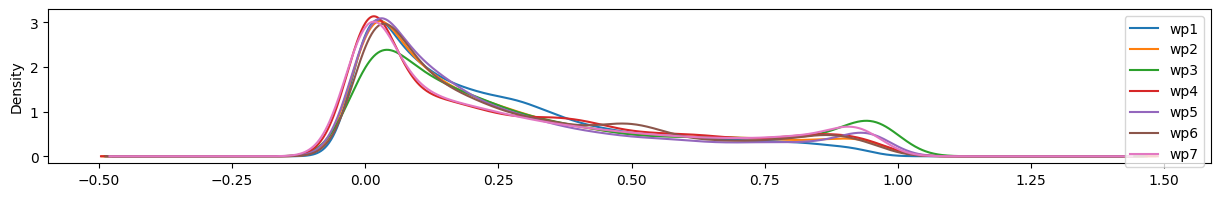

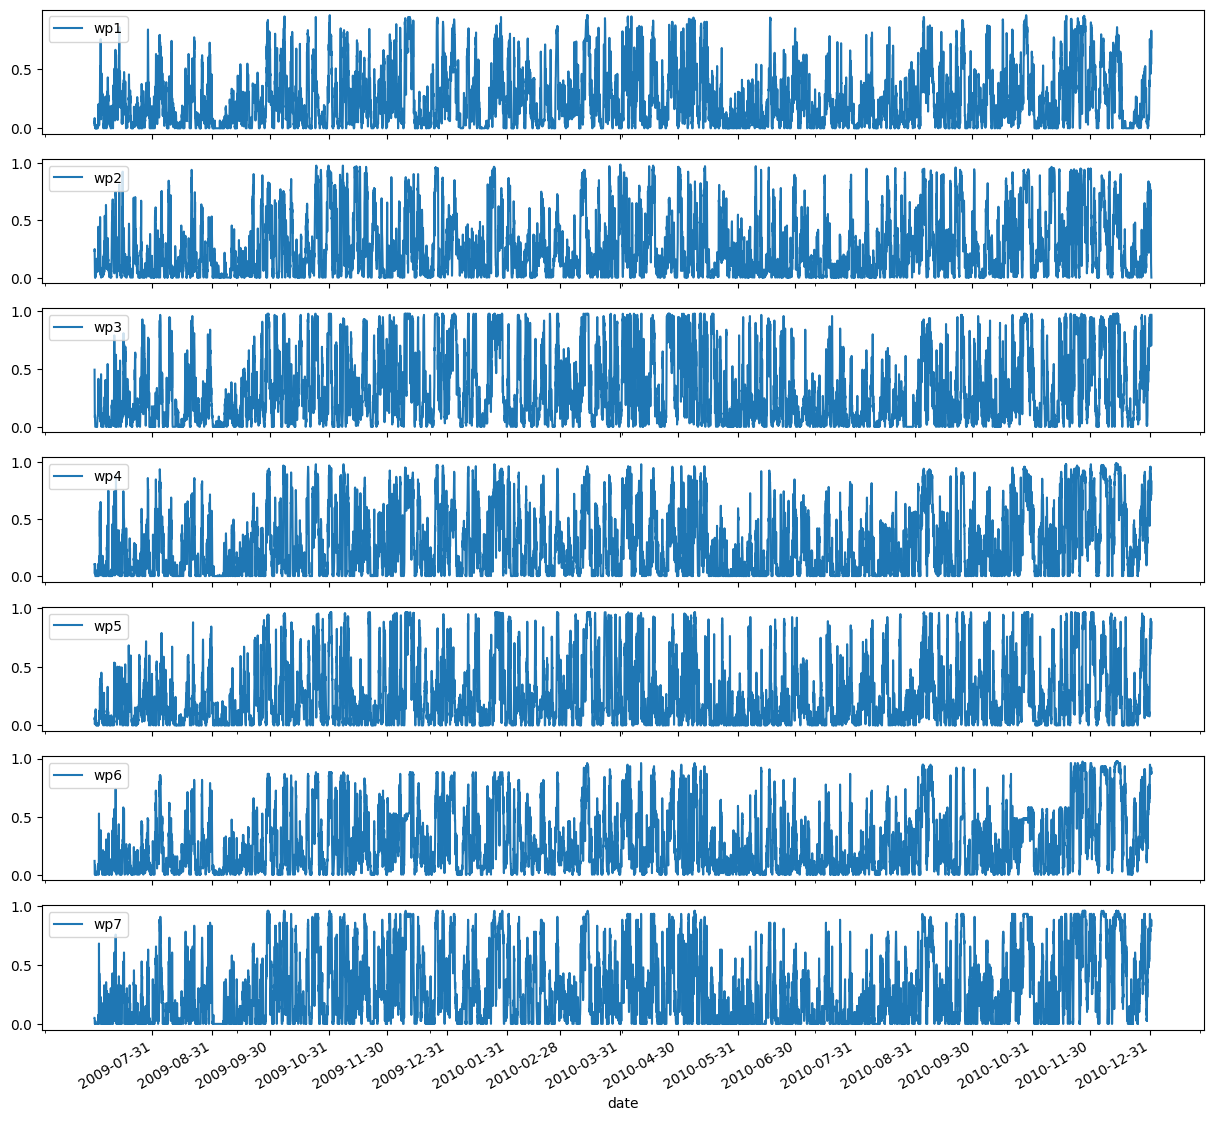

       count      mean       std  min    25%    50%    75%    max
wp1  13176.0  0.242061  0.238976  0.0  0.045  0.170  0.366  0.947
wp2  13176.0  0.262165  0.271637  0.0  0.042  0.164  0.407  0.989
wp3  13176.0  0.325916  0.313976  0.0  0.059  0.208  0.534  0.978
wp4  13176.0  0.276041  0.286975  0.0  0.022  0.176  0.452  0.992
wp5  13176.0  0.258475  0.280703  0.0  0.040  0.152  0.384  0.966
wp6  13176.0  0.272651  0.271611  0.0  0.053  0.171  0.447  0.974
wp7  13176.0  0.284249  0.301347  0.0  0.025  0.177  0.480  0.960
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13176 entries, 2010-09-23 13:00:00 to 2010-01-28 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wp1     13176 non-null  float64
 1   wp2     13176 non-null  float64
 2   wp3     13176 non-null  float64
 3   wp4     13176 non-null  float64
 4   wp5     13176 non-null  float64
 5   wp6     13176 non-null  float64
 6   wp7     13176 non-null  floa

In [11]:
%reset_selective -f "temp_&"
temp_df = train_data.visualize_sampled_dataframe(frac=1.0)
print(temp_df.describe().T)
print(temp_df.info())
%reset_selective -f "temp_&"

In [12]:
train_ds, test_ds = train_data.split_data(prediction_length=3*24, percentage=80)
train_ds, test_ds

your dataset was split baesd on these parameters: {'method': 'static', 'prediction_length': 72, 'windows': 3}. If you would like to access the parameters use property TSData.ds_split_parameters


(PandasDataset<size=7, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>,
 PandasDataset<size=7, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>)

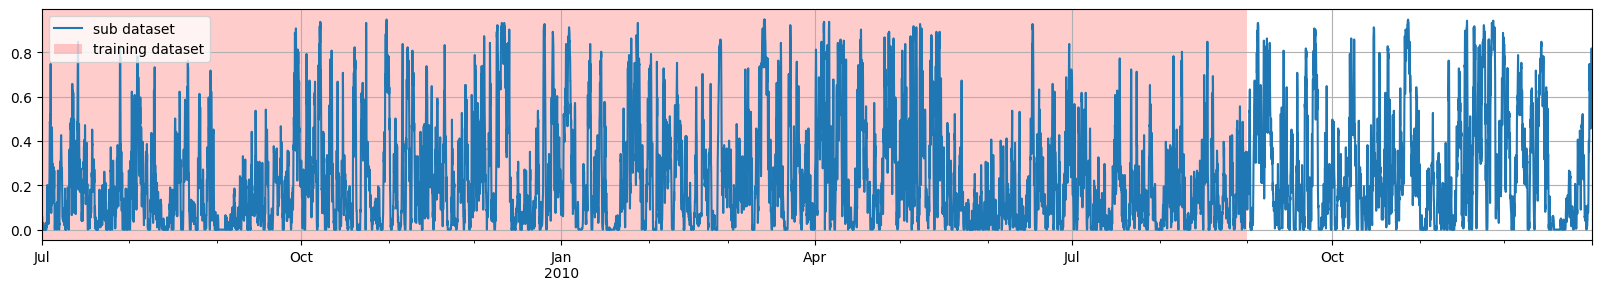

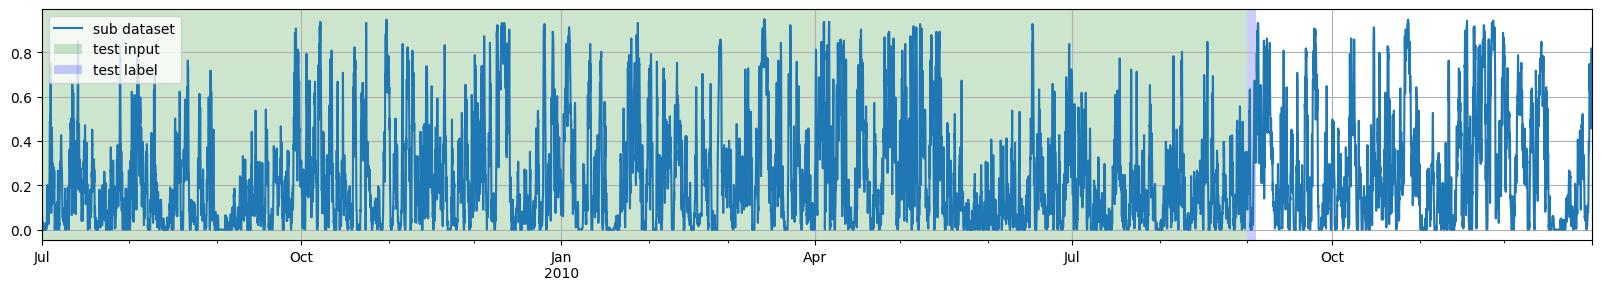

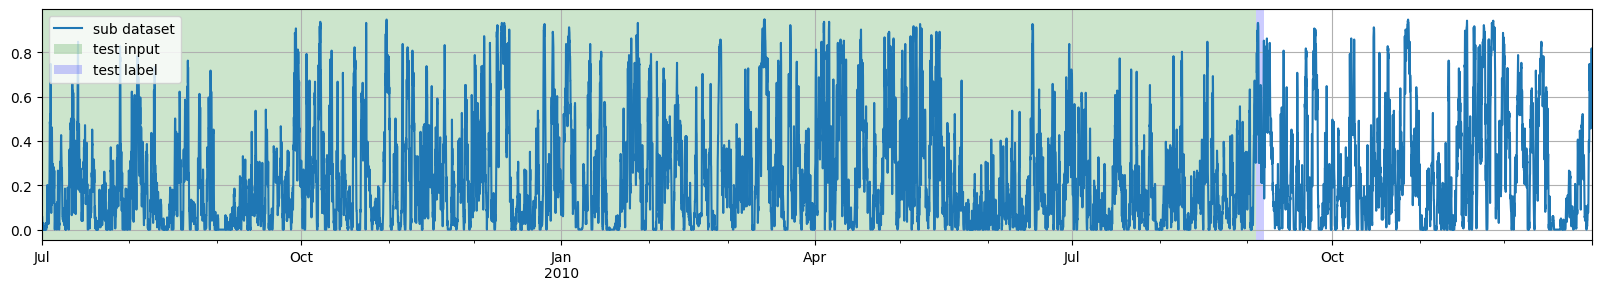

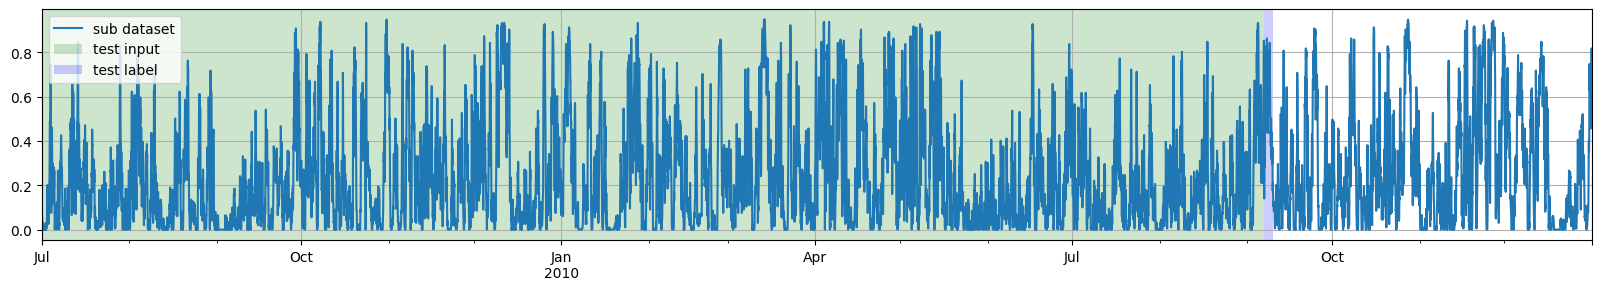

your dataset was split baesd on these parameters: {'method': 'static', 'prediction_length': 72, 'windows': 3}. If you would like to access the parameters use property TSData.ds_split_parameters


In [13]:
# given that test data is randomized and the dataset has 7 different series, we are going to end up with 22 plots. I have used only one of the time series to demonstrate how training pair sampling is conducted
%reset_selective -f "^temp_"
temp_df = train_data.dataframe[['wp1']]
temp_data = TSData(temp_df)
temp_train_ds, temp_test_ds = temp_data.split_data(prediction_length=3*24, percentage=80, plot_data=True)
%reset_selective -f "^temp_"

In [14]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator



def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]


estimator = DeepAREstimator(
    freq=train_ds.freq, prediction_length=train_data.ds_split_parameters["prediction_length"], trainer=Trainer(epochs=1)
)

In [15]:
estimator = DeepAREstimator(freq=train_ds.freq, prediction_length=train_data.ds_split_parameters["prediction_length"], trainer=Trainer(epochs=10))
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:55<00:00,  1.10s/it, epoch=10/10, avg_epoch_loss=-1.41]


In [16]:
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)


In [17]:
N=7
n_plot = 3
indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)

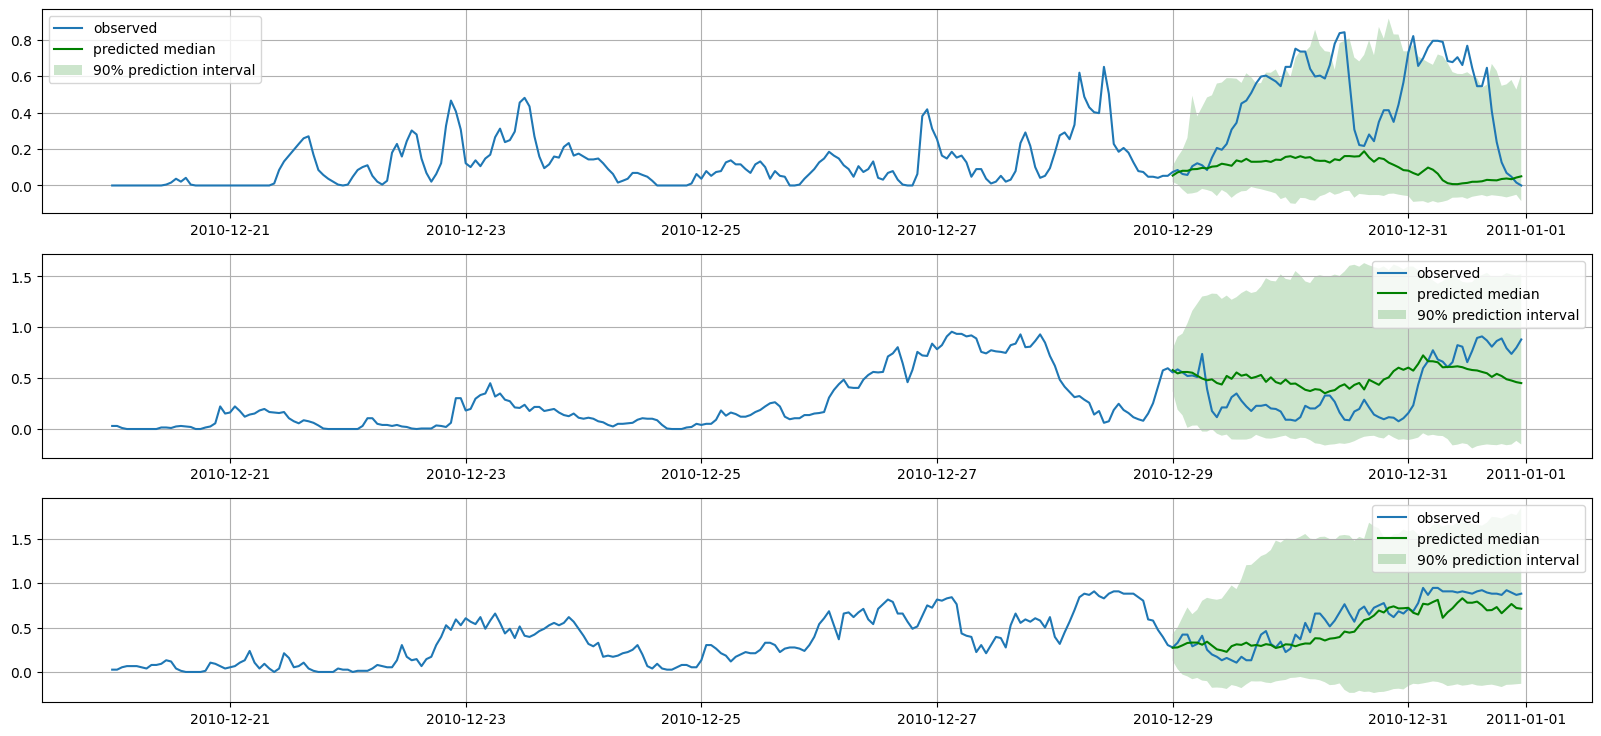

In [18]:
fig, axes = plt.subplots(n_plot, 1, figsize=(20, n_plot * 3))


for index, ax in zip(indices, axes):
    ax.plot(tests[index][-4 * train_data.ds_split_parameters["prediction_length"] :].to_timestamp())
    plt.sca(ax)
    forecasts[index].plot(intervals=(0.9,), color="g")
    plt.legend(["observed", "predicted median", "90% prediction interval"])